In [1]:
# In[1]:


import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
import astropy.units as u
from tqdm import tqdm
from popsims.galaxy import Disk, Halo, GalacticComponent
from popsims import sample_from_powerlaw
import popsims
from gala.units import UnitSystem
import pandas as pd
from scipy.interpolate import interp1d, griddata, InterpolatedUnivariateSpline
from astropy.io.votable import parse_single_table
import numba
plot_style()
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm import tqdm
#get_ipython().run_line_magic('matplotlib', 'inline')


# In[2]:
from popsims.plot_style import plot_style
plot_style()


path_isochrone='../data/isochrones/'
path_data='../data/images/'
path_streamdata='../data/stream/'
path_pipeline='../data/pipeline/'
path_pandas= '../data/pandas/'

In [2]:
0.3333*(1.4+1.8+1.8)

1.6664999999999999

In [3]:
#plt.style.use('dark_background') #for posters

In [121]:
rgc='10_20'
fname=path_isochrone+'/simulated_df_at_M31_normalized_extended_rgc{}.csv'.format(rgc)
df=pd.read_csv(fname)#, usecols=['MH', 'appF087mag', 'galaxy']).query('MH<-1')

#put to the desired distance modulus 
mw_df= df.query("galaxy == 'MW'").reset_index(drop=True)
m31_df= df.query("galaxy =='M31'").reset_index(drop=True)

In [5]:
memory_usage = df.memory_usage(deep=True).sum() / 1024 ** 2 # convert to MB
print(f"Memory usage: {memory_usage:.2f} MB")

Memory usage: 1075.38 MB


In [6]:
df.columns

Index(['Unnamed: 0', 'MH', 'appgmag', 'appimag', 'appF062mag', 'appF087mag',
       'g-i', 'galaxy', 'x_coord', 'y_coord'],
      dtype='object')

In [7]:
import matplotlib as mpl
from matplotlib import patches

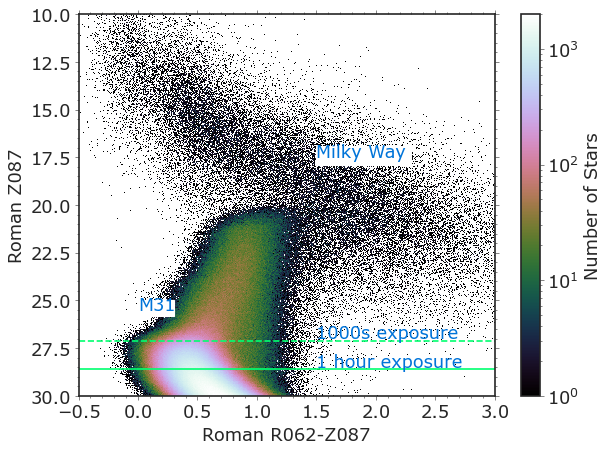

In [65]:
fig, ax=plt.subplots()

c= ax.hist2d(df.appF062mag-df.appF087mag, df.appF087mag, bins=500, norm=mpl.colors.LogNorm(), \
             range=[[-0.5, 3], [10, 30]], cmap='cubehelix')

ax.invert_yaxis()
cbar=plt.colorbar(c[3], label='Number of Stars')

ax.axhline(28.59, linestyle='-', c='#01FF70')
ax.axhline(27.15, linestyle='--', c='#01FF70')
ax.set(xlabel= 'Roman R062-Z087', ylabel='Roman Z087')

rect = patches.Rectangle( (0.0,25),0.3, 0.8, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
ax.add_patch(rect)
rect = patches.Rectangle( (1.5,16.9),0.8, 1.0, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
ax.add_patch(rect)
ax.text(0.0, 25.5, "M31",c='#0074D9', fontsize=16)
ax.text(1.5, 17.5, "Milky Way",c='#0074D9', fontsize=16)

ax.text(1.5, 27.15-0.15, "1000s exposure",c='#0074D9', fontsize=16)
ax.text(1.5, 28.69-0.2, "1 hour exposure",c='#0074D9', fontsize=16)

ax.set(ylim=[30, 10])
ax.minorticks_on()
plt.tight_layout()
plt.savefig('../figures/simulated_CMD_Roman_M31.jpeg', bbox_inches='tight')
plt.savefig('../figures/simulated_CMD_Roman_M31.pdf', bbox_inches='tight')

In [9]:
path_pandas= '/users/caganze/research/stellarstreams/data/pandas/'
data=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()
#data=(data[data.FeH_phot.values <0.5]).reset_index(drop=True) #remove metalpoor star


In [10]:
path_pandas+'M31_{}kpc_new.vot'.format(rgc)

'/users/caganze/research/stellarstreams/data/pandas/M31_10_20kpc_new.vot'

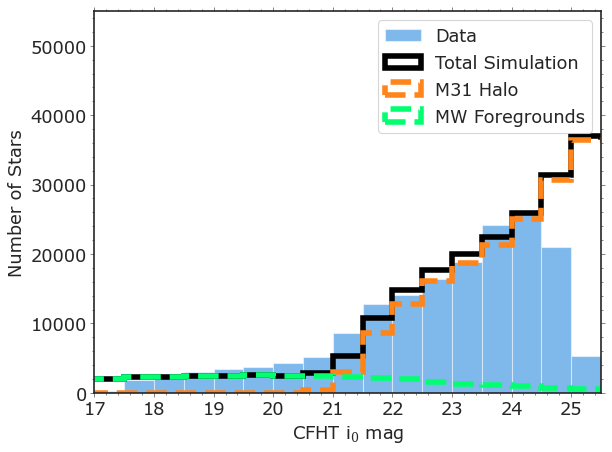

In [26]:
fig, ax=plt.subplots()
from astropy.io.votable import parse_single_table

_= plt.hist(data.i0, bins= np.arange(15, 27, 0.5), log=False, label='Data',alpha=0.5, color='#0074D9')
#_= plt.hist(data.g, bins= np.arange(15, 27, 0.5), log=False, label='Data',  hatch='/',alpha=0.2, color='#001f3f')
_= plt.hist(df.appimag.values,
            bins= np.arange(15, 30, 0.5), log=False, histtype='step', linewidth=5, \
            label='Total Simulation', linestyle='-', color='k')
_= plt.hist(df.appimag[df.galaxy.values == 'M31'].values,
            bins= np.arange(15, 30, 0.5), log=False, histtype='step',\
            linestyle='--', linewidth=5, label='M31 Halo', color='#FF851B')

_= plt.hist(df.appimag[df.galaxy.values == 'MW'].values,
            bins= np.arange(15, 30, 0.5), log=False, histtype='step', linewidth=5, \
            label='MW Foregrounds', linestyle='--', color='#01FF70')


ax.set(xlabel='CFHT i$_0$ mag', ylabel='Number of Stars',  ylim=[0,55_000], xlim=[17, 25.5])
ax.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig('../figures/lf_check_rgc{}.jpeg'.format(rgc), bbox_inches='tight')
plt.savefig('../figures/lf_check_rgc{}.pdf'.format(rgc), bbox_inches='tight')

In [12]:
'lf_check_rgc{}.jpeg'.format(rgc)

'lf_check_rgc10_20.jpeg'

In [13]:
rgc

'10_20'

simulated_CMD_CFHT_rgc10_20.jpeg


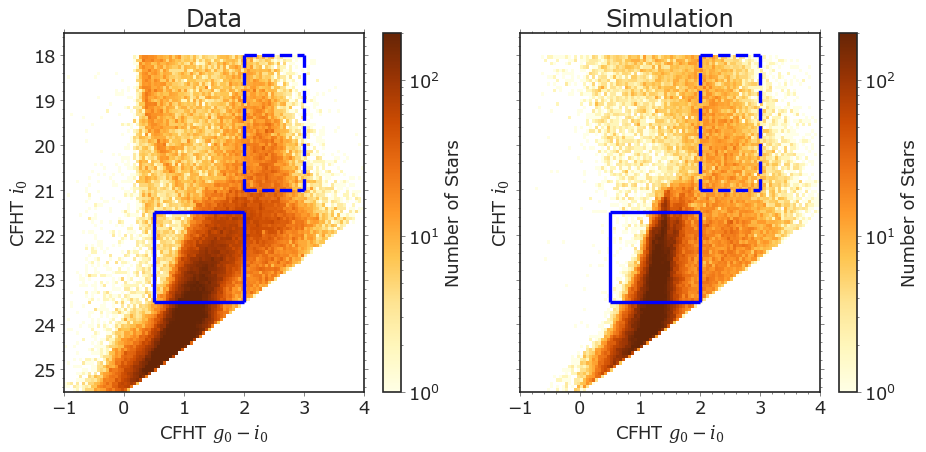

In [14]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

#ax[0].scatter(data.g-data.i, data.g, c='b', s=1, marker=',', alpha=0.05)
#ax[0].scatter(data.g0-data.i0, data.i0, c='k', s=1, marker=',', alpha=0.05)
c= ax[0].hist2d(data.g0-data.i0, data.i0, bins=100, range=[[-1, 4], [18, 25.5]], norm=mpl.colors.LogNorm(vmin=1, vmax=200),  cmap='YlOrBr')
cbar=plt.colorbar(c[3], label='Number of Stars')

df0= df[np.logical_and.reduce([df.appgmag.values <data.g0.max(), \
                       df.appgmag.values >data.g0.min(),\
                        df.appimag.values >data.i0.min(),\
                       df.appimag.values < data.i0.max()])]
                       #df.galaxy.values == 'M31')]) ]

#df1= df[np.logical_and.reduce([df.appgmag.values <data.g0.max(), \
#                       df.appgmag.values >data.g0.min(),\
#                        df.appimag.values >data.i0.min(),\
#                       df.appimag.values < data.i0.max(),
#
#                           (df.galaxy.values == 'MW')]) ]

#ax[1].scatter(df0.appgmag-df0.appimag, df0.appimag, s=1, marker=',', alpha=0.05, label='M31',  color='#0074D9')
#ax[1].scatter(df1.appgmag-df1.appimag, df1.appimag, s=1, marker=',', alpha=0.05, label='MW', color='#0074D9')

c= ax[1].hist2d(df0.appgmag-df0.appimag, df0.appimag, range=[[-1, 4], [18, 25.5]], bins=100, norm=mpl.colors.LogNorm(vmin=1, vmax=200),  cmap='YlOrBr')
cbar=plt.colorbar(c[3], label='Number of Stars')
                           
#ax[1].vlines()
for a in ax:
    #a.set(xlabel='g0-i0', ylabel='g0', xlim=[-2, 5])
    #a.minorticks_on()
    
    a.hlines(21.5, xmin=0.5, xmax=2., color='b', linewidth=3)
    a.vlines(0.5, ymin=21.5, ymax=23.5, color='b',linewidth=3)
    a.vlines(2, ymin=21.5, ymax=23.5, color='b', linewidth=3)
    a.hlines(23.5, xmin=0.5, xmax=2., color='b', linewidth=3)
    
    a.hlines(18, xmin=2, xmax=3., color='b', linestyle='--', linewidth=3)
    a.vlines(2, ymin=18, ymax=21, color='b',linestyle='--', linewidth=3)
    a.vlines(3, ymin=18, ymax=21, color='b', linestyle='--', linewidth=3)
    a.hlines(21, xmin=2, xmax=3, color='b', linestyle='--', linewidth=3)
  
    a.set(ylim=[25.5, 17.5], xlim=[-1, 4], xlabel=r'CFHT $g_0-i_0$', ylabel=r'CFHT $i_0$')
    
    #rect = patches.Rectangle( (2,20), \
    #                           1.2, 0.5, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
   # a.add_patch(rect)
    
    #rect = patches.Rectangle( (0.2,24), \
    #                           1.2, 0.5, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    #a.add_patch(rect)
    #a.text(2.0, 20.3, "Milky Way",c='#FF851B', fontsize=16)
    #a.text(0.2, 24.3, "M31",c='#FF851B', fontsize=16)
    
#ax[-1].legend()
#ax[-1].legend(markerscale=20)
ax[-1].minorticks_on()
ax[0].set(title='Data')
ax[1].set(title='Simulation')

plt.tight_layout()
plt.savefig('../figures/simulated_CMD_CFHT_rgc{}.jpeg'.format(rgc),  bbox_inches='tight')
print('simulated_CMD_CFHT_rgc{}.jpeg'.format(rgc))

In [93]:
df.galaxy=='M31'

0           True
1           True
2           True
3           True
4           True
           ...  
8542958    False
8542959    False
8542960    False
8542961    False
8542962    False
Name: galaxy, Length: 8542963, dtype: bool

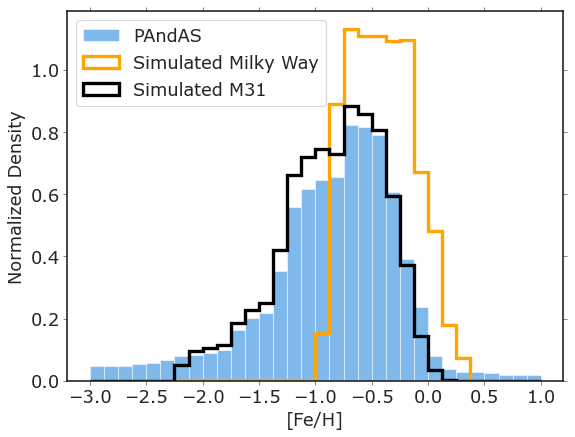

In [247]:
fig, ax=plt.subplots()
_= ax.hist(data.FeH_phot.values, range=[-3, 1], density=True, bins=32, label='PAndAS', log=False, alpha=0.5,  color='#0074D9')
_= ax.hist(df.MH[df.galaxy=='MW'], range=[-3, 1], density=True, histtype='step',bins=32, lw=3,\
           label='Simulated Milky Way', color='orange', log=False)
_= ax.hist(df.MH[df.galaxy=='M31'], range=[-3, 1], density=True, histtype='step',bins=32, \
           lw=3, label='Simulated M31', color='k', log=False)
ax.set(xlabel='[Fe/H]', ylabel='Normalized Density')
ax.legend()
plt.savefig('../figures/simulated_metallicities_rgc{}.jpeg'.format(rgc),  bbox_inches='tight')

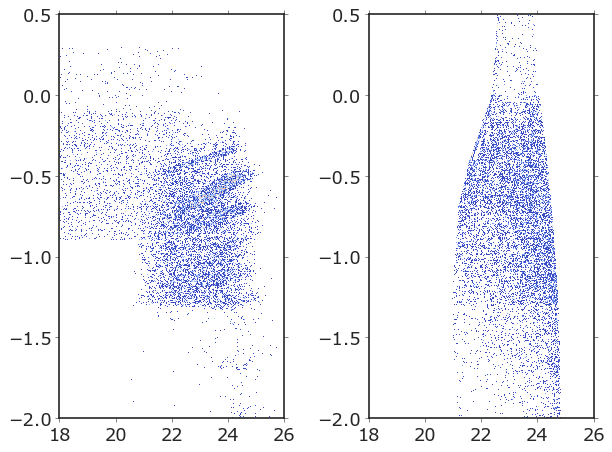

In [91]:
fig,ax=plt.subplots(ncols=2)

_= ax[0].hist2d(df0.appimag ,df0.MH.values,  norm=mpl.colors.LogNorm(), range=[[18, 26], [-2, 0.5]], bins=1000, cmap='coolwarm')
_= ax[1].hist2d(data.i0, data.FeH_phot.values,  norm=mpl.colors.LogNorm(), range=[[18, 26], [-2, 0.5]], bins=1000, cmap='coolwarm')

plt.tight_layout()

In [195]:
def combined_isochrones():
    path_isochrones = '../data/isochrones/'
    from astropy.io import ascii
    fls= glob.glob(path_isochrones+'/*.txt')
    dfs=[]
    for f in fls:
        dfs.append(ascii.read(f).to_pandas())
    comb_isos=pd.concat(dfs).reset_index(drop=True)
    return comb_isos    

In [197]:
isos= combined_isochrones()

In [248]:
isos_m31= isos[(10**isos.logAge)/1e9 > 5][['gmag', 'imag', 'MH']].dropna()


In [250]:
#isos_m31

In [251]:
import matplotlib

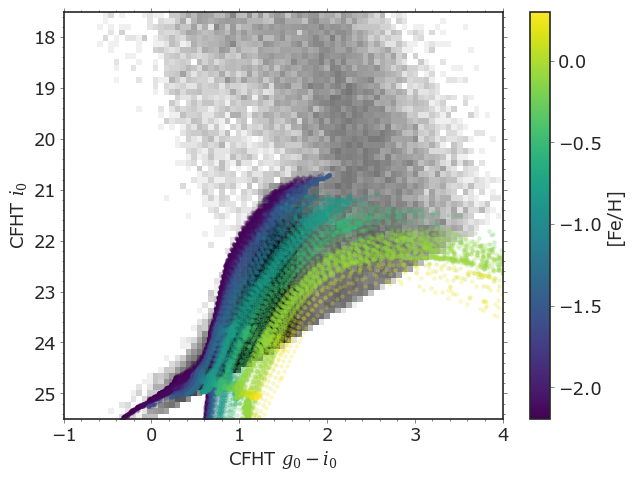

In [256]:
# Create a 2D histogram
x=(df0.appgmag-df0.appimag).values
y= df0.appimag.values
z= df0.MH.values

fig, ax=plt.subplots()
_= ax.hist2d(x, y, bins=80, norm=mpl.colors.LogNorm(vmin=1, vmax=300),  cmap='Greys')
ax.invert_yaxis()

ax.minorticks_on()

cmap = plt.cm.viridis

# Create a normalization function based on the data values
norm =matplotlib.colors.Normalize(vmin=min(np.unique(isos_m31.MH)), vmax=max(np.unique(isos_m31.MH)))

# Create a ScalarMappable object to map normalized data to colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array to trigger colormap scaling


for met in np.unique(isos_m31.MH):
    isosx= isos_m31[isos_m31.MH==met]
    color= sm.to_rgba(met)
    sort = np.argsort(isosx.imag.values)
    ax.plot((isosx.gmag-isosx.imag).values[sort], isosx.imag.values[sort]+24.7, '.', c=color, alpha=0.2)

cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='[Fe/H]')

plt.tight_layout()

ax.set(ylim=[25.5, 17.5], xlim=[-1, 4], xlabel=r'CFHT $g_0-i_0$', ylabel=r'CFHT $i_0$')
plt.savefig('../figures/simulated_CMD_CFHT_with_isos_rgc{}.jpeg'.format(rgc),  bbox_inches='tight')